# VLM for KOMO

In [1]:
import time
import rowan
import torch
import numpy as np
import robotic as ry
import matplotlib.pyplot as plt

from utils import grasping_within_komo_definition

In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Name: {torch.cuda.get_device_name(device)}" if device.type == "cuda" else "Using cpu")

Device Name: NVIDIA GeForce RTX 3090


## Prepare your scene

In [4]:
C = ry.Config()
C.addFile(ry.raiPath("./scenarios/push_blob.g"))

midpoint = np.array([-0.105, 0.2, 0.745])

C.addFrame("bin") \
    .setPosition(midpoint+np.array([-.22,.2,0])) \
    .setShape(ry.ST.box, size=[0.21, .36, .15]) \
    .setColor([28/255, 18/255, 210/255]) \

def sample_rectangular_arena(width=0.4, height=0.4, z_coord=0.745, center_point=[0, 0]):
    x = center_point[0] + np.random.uniform(-width / 2, width / 2)
    y = center_point[1] + np.random.uniform(-height / 2, height / 2)
    return [x, y, z_coord]

midpoint = sample_rectangular_arena(width=.68, height=.6, center_point=[.19, .32])

base_quat = [-1/np.sqrt(2), 1/np.sqrt(2), 0 ,0 ]
rel_quat = rowan.from_axis_angle([0,1,0], np.random.uniform(0, 2*np.pi))

C.addFrame("blob") \
    .setPosition(midpoint) \
    .setShape(ry.ST.capsule, size=[.08, .07]) \
    .setColor([106/255, 24/255, 79/255]) \
    .setQuaternion(rowan.multiply(base_quat, rel_quat))
C.view()

0

## Define your model (VLM)

In [5]:
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor

model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype="auto",
    device_map=device
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

/home/eckart/miniconda3/envs/project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


## Take a picture of the scene

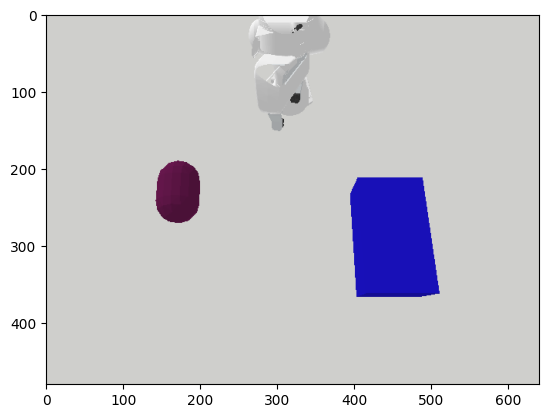

In [6]:
bot = ry.BotOp(C, False)
bot.home(C)
bot.gripperMove(ry._left)

rgb, depth = bot.getImageAndDepth("topCamera")

img_idx = 1
image_path = "./scene_image0.jpg"
plt.imsave(image_path, rgb)
plt.imshow(rgb)

## Prepare initial prompt

In [7]:
from prompting import prompt_qwen

task_description = "Put the blob in the bin."

with open("./prompts/komo_tutorial.txt", 'r') as file:
        komo_tutorial = file.read()

with open("./prompts/problem_definition.txt", 'r') as file:
    problem_definition = file.read()

frame_names = [line for line in C.getFrameNames() if not line.startswith("l_")]
frame_names.append("l_gripper")
frame_names.append("l_palm")

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": komo_tutorial,
            },
            {
                "type": "image",
                # "image": image_path,
                "image": "./example_image.jpg",
            },
            {
                "type": "text",
                "text": f"{problem_definition}{task_description}",
                # "text": "Explain how many phases the problem should have.",
            },
            {
                "type": "text",
                "text": f"Here is a list of all available frames: {frame_names}",
            },
        ],
    },
    # {
    #     "role": "system",
    #     "content": [
    #         {
    #             "type": "text",
    #             "text": "The problem should have 4 phases.",
    #         },
    #     ],
    # },
    # {
    #     "role": "user",
    #     "content": [
    #         {
    #             "type": "text",
    #             "text": "Explain what happens in each phase.",
    #         },
    #     ],
    # }
]

## Loop until the problem in solved

In [8]:
ATTEMPT_COUNT = 10

for i in range(ATTEMPT_COUNT):
    komo_definition = prompt_qwen(model, processor, device, messages)

    # Remove junk
    komo_definition = [line for line in komo_definition.splitlines() if line.strip() not in ("```python", "```")]
    komo_definition = "\n".join(komo_definition[1:])
    print(komo_definition)
    komo_definition_clean = komo_definition.splitlines()
    komo_definition_clean = [line for line in komo_definition_clean if not line.startswith("C ") and not line.startswith("C.")]
    komo_definition_clean = "\n".join(komo_definition_clean)
    print("CLEANED VERSION", "-"*20)
    print(komo_definition_clean)
    print("-"*30)
    system_message = {
        "role": "system",
        "content": [
            {
                "type": "text",
                "text": komo_definition,
            },
        ],
    }
    messages.append(system_message)

    komo: ry.KOMO = None
    try:
        exec(komo_definition_clean)
        ret = ry.NLP_Solver(komo.nlp(), verbose=0).solve()

    except Exception as e:
        print("="*10, "ERROR", "="*10)
        print(e)
        print("="*27)
        user_message = {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": f"An error has occurred, try again: {e}.\nRewrite the whole problem again with the appropriate fixes and nothing else.",
                },
            ],
        }
        messages.append(user_message)
        continue
    
    print(ret)
    if not ret.feasible:
        user_message = {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "The KOMO problem that you have defined seems to not be feasible, please try again.\nRewrite the whole problem again with the appropriate fixes and nothing else.",
                },
            ],
        }
        messages.append(user_message)
        continue

    # Visualize solution
    qs = komo.getPath()

    for q in qs:
        C.setJointState(q)
        C.view()
        time.sleep(3./len(qs))

    # Identify phases where we grasp
    switch_indices = grasping_within_komo_definition(komo_definition)

    # Execute on robot
    prev_s = 0
    for i, s in enumerate(switch_indices):
        
        # Moving
        bot.moveAutoTimed(qs[prev_s:s])
        while bot.getTimeToEnd() > 0:
            bot.sync(C)

        # Grasping
        if i % 2 == 0:
            bot.gripperClose(ry._left)
        else:
            bot.gripperMove(ry._left)
            
        prev_s = s

    
    rgb, depth = bot.getImageAndDepth("topCamera")

    image_path = f"./scene_image{img_idx}.jpg"
    plt.imsave(image_path, rgb)
    plt.imshow(rgb)
    img_idx += 1

    user_message = {
        "role": "user",
        "content": [
            {
                "type": "image",
                # "image": image_path,
                "image": "./example_image.jpg",
            },
            {
                "type": "text",
                "text": "Looking at this image, would you say that the task has been solved correctly? Start with a simple yes or no, then explain your answer.",
            },
        ],
    }
    messages.append(user_message)

    image_evaluation = prompt_qwen(model, processor, device, messages)
    system_message = {
        "role": "system",
        "content": [
            {
                "type": "text",
                "text": image_evaluation,
            },
        ],
    }
    messages.append(system_message)

    print(image_evaluation)
    print("-"*30)
    s = image_evaluation.strip().lower()

    if s.startswith("yes"):
        break
    else:
        user_message = {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Retry generating the KOMO problem as defined previously.\nRewrite the whole problem again with the appropriate fixes and nothing else.",
                },
            ],
        }
        messages.append(user_message)


# Define the configuration
C = ry.Configuration()

# Define the blob and bin positions
blob_position = [0.5, 0.5, 0.1]
bin_position = [0.7, 0.5, 0.1]

# Define the joint limits
joint_limits = {
    'l_gripper': [-0.5, 0.5],
    'l_palm': [-0.5, 0.5]
}

# Define the phases and slices
phases = 4
slices_per_phase = 10
key_order = 2

# Define the KOMO problem
komo = ry.KOMO(C, phases, slices_per_phase, key_order, enable_collisions=False)

# Add the joint state objective
komo.addControlObjective([], 0, 1e-1)
komo.addControlObjective([], 1, 1e0)

# Add the position difference objective
komo.addObjective([1], ry.FS.positionDiff, ['l_gripper', 'blob'], ry.OT.eq, [1e1])
komo.addObjective([2], ry.FS.positionDiff, ['l_gripper', 'bin'], ry.OT.eq, [1e1])

# Add the joint limit constraints
for joint in joint_limits:
    komo.addObjective([], ry.FS.jointLimits, [joint], ry.OT.ineq, [1e1], joint_limits[joint])

# Add the collision constraint
komo.addObjective([], ry.FS.accumulatedCollisions, [], ry.O

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.44 GiB. GPU 0 has a total capacity of 23.66 GiB of which 2.38 GiB is free. Including non-PyTorch memory, this process has 20.69 GiB memory in use. Of the allocated memory 18.17 GiB is allocated by PyTorch, and 2.20 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)